# Alfvén Modes

Problema molt semblant al de una corda amb estructura longitudinal

(<dedalus.core.subsystems.Subproblem object at 0x12e82b740>,)
2025-05-09 11:15:48,286 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 5s, Remaining: 0s, Rate: 2.2e-01/s
evals.size (before)  130
evals.size (after removing inf)  126
evals.size (after removing < 0)  126
exact_soln [ 7.37232117 18.65069051 23.96402319 35.86490619 42.41442022]

evals size 126
true_evals size  126
First 5 Eigenvalues (sqrt): [ 7.34762358 18.65814582 23.90737243 35.89278471 42.36820463]
First 5 True eigenvalues: [ 7.37232117 18.65069051 23.96402319 35.86490619 42.41442022]
Relative error: [0.00335004 0.00039973 0.00236399 0.00077732 0.00108962]


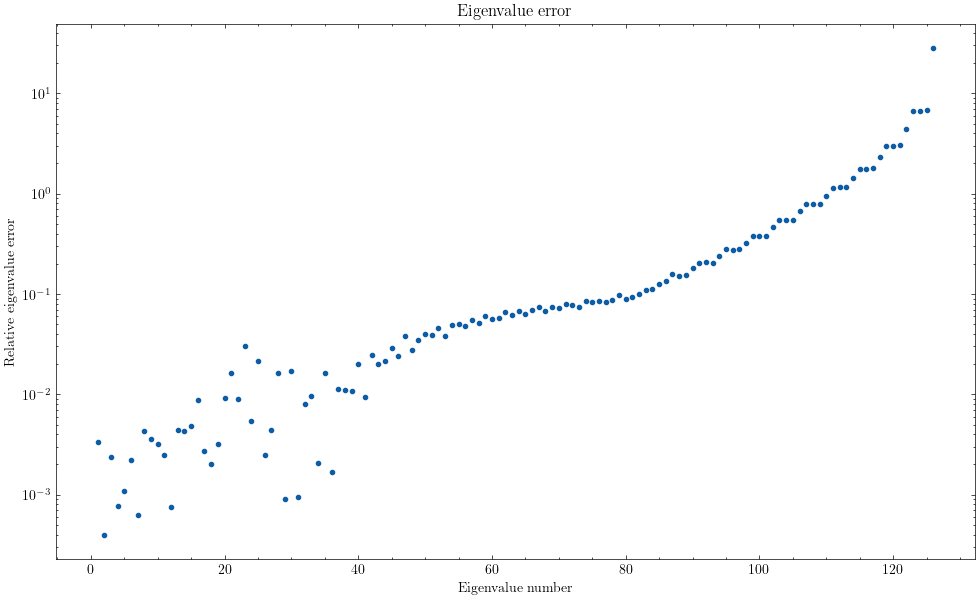

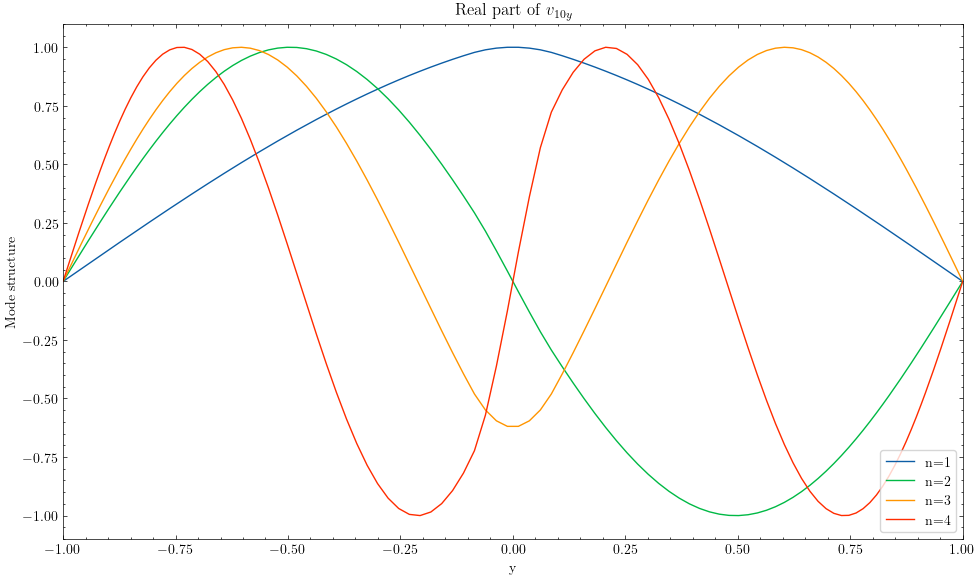

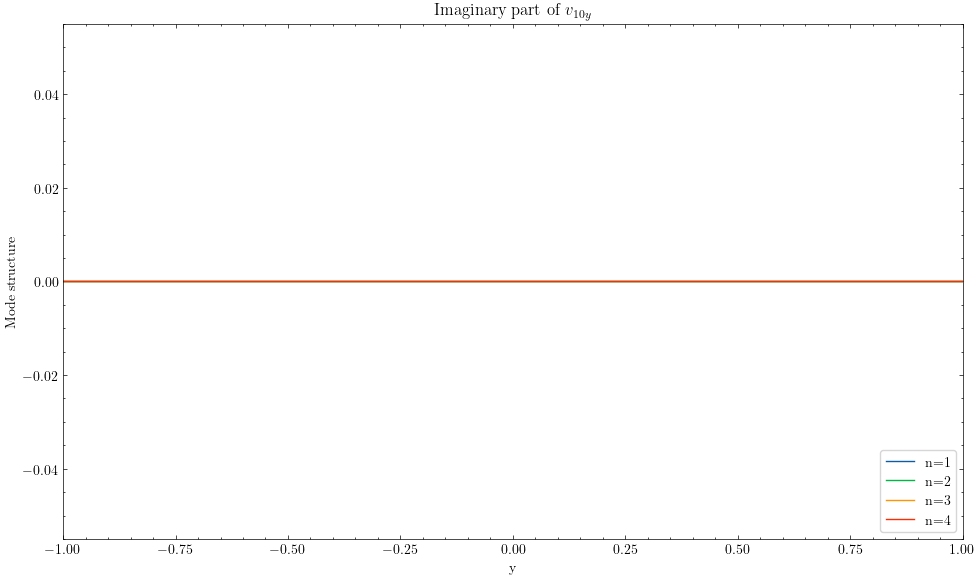

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
from scipy.optimize import fsolve
import logging
logger = logging.getLogger(__name__)
import scienceplots
plt.style.use('science')



""" Funcions per calcular els autovalors exactes """
# Funcions den Monxo per calcular els autovalors exactes d'una corda amb densitat variable.
def dispersion_relation(omega):
    disprel_even = (np.sqrt(vAp2)/np.sqrt(vAc2)) * np.cos(omega * (xmax - xp) / np.sqrt(vAc2)) * np.cos(omega * xp / np.sqrt(vAp2)) - \
        np.sin(omega * (xmax - xp) / np.sqrt(vAc2)) * np.sin(omega * xp / np.sqrt(vAp2))
    disprel_odd = (np.sqrt(vAp2)/np.sqrt(vAc2)) * np.cos(omega * (xmax - xp) / np.sqrt(vAc2)) * np.sin(omega * xp / np.sqrt(vAp2)) + \
        np.sin(omega * (xmax - xp) / np.sqrt(vAc2)) * np.cos(omega * xp / np.sqrt(vAp2))
    disprel = disprel_even * disprel_odd
    return disprel

def get_eigenvalues(Nevals):
    Nsol = 0
    omega0 = 1
    omega_step = 0.5
    exact_soln = np.array([])
    while Nsol < Nevals:
        sol = fsolve(dispersion_relation, omega0)
#         print('omega0, sol ', omega0, sol)
        if sol > 0:
            exact_soln = np.append(exact_soln, sol)
            exact_soln = np.unique(exact_soln.round(decimals=8))
#         print('exact_soln, exact_soln**2 ', exact_soln, exact_soln**2)
#         print(exact_soln.size)
        Nsol = exact_soln.size
        omega0 = omega0 + omega_step
    print('exact_soln', exact_soln[0:5])
#    print('exact_soln**2 ', exact_soln**2)
    print()
    return exact_soln

# En el cas de kz = 0 hauríem de recuperar els resultats de la corda amb densitat variable!
# No ens serveix si kz != 0...



""" Paràmetres """
Nx = 128 # amb 32 ja no és smooth...
dtype = np.complex128 # malla en la que es treballa: 128 complexes, ja que hem definit Nx = 128



""" Límits del domini """
xmax = 1
xmin = -1 # = -xmax
# Position of boundaries between different parts of the system (prominence and corona).
xp = 0.1
# xc ∈ [-1, -0.1], xc ∈ [0.1, 1]
# Square of the wave velocity in the two parts of the system.
vAp2 = 9#1 # 9
vAc2 = 36#6 # 36
# And the Alfvén speed too.
# velocitat dedins menor que defora



""" Bases """
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.Legendre(xcoord, size=Nx, bounds=(xmin, xmax)) # Definim una base amb uns altres límits. Chebyshev menos error?



""" Camps """
### Velocitats ###
v = dist.Field(name='v', bases=xbasis) # v = field of the wave function: v10y
# Definesc la velocitat com en oceano: (u,v,w) per no liar subíndexos i derivades.

### Espai real ###
x = dist.local_grid(xbasis) # punts del domini

### Constants ###
vA2 = dist.Field(name='vA2', bases=xbasis) # vA2 = Alfven velocity squared ----- és interessant definir-la directament al quadrat ja que és un camp i així evitam fer c.evaluate()**2
vA2['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [vAc2, vAp2, vAc2]) # Representa la velocitat d'Alfven en l'espai real ('g') a trossos.
kz = dist.Field(name='kz', bases=xbasis) # kz = Wave number in the z direction
#kz['g'] = 0 # Representa el nombre d'ona en la direcció z en l'espai real ('g').
kz['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [0, 0, 0]) # Representa el nombre d'ona en la direcció z en l'espai real ('g') a trossos.

### Autovalors ###
s = dist.Field(name='s') # AUTOVALOR ω^2 = s

### Auxiliars de les derivades ###
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')



""" Substitucions """
### Derivades espacials ###
dx = lambda A: d3.Differentiate(A, xcoord) # Derivative operator
lift_basis = xbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
vx = dx(v) + lift(tau_1) # First-order reduction of the velocity in the y direction
vxx = dx(vx) + lift(tau_2) # Second-order reduction of the velocity in the y direction
# No és convenient posar directament dx(v) a l'equació ja que faltaria el lift... s'ha de definir bé la derivada
# No definim derivada temporal ja que és un EVP!!!



""" Problem """

# 1 equació i 1 incògnita
problem = d3.EVP([v, tau_1, tau_2], eigenvalue=s, namespace=locals())

# Problema d'ones d'Alfvén ~ corda guitarra amb densitat variable
problem.add_equation("s * v  +  vA2 * vxx  =  0") # (18')
problem.add_equation("v(x=xmin) = 0")
problem.add_equation("v(x=xmax) = 0")


# REPRESENTAR HIBRIDS INTERNS I EXTERNS AMB AJUDA MATHEMATICA
# DESPRÉS REPETIR PER KZ = 0.01 EN L'ALTRE PROGRAMA I REPRESENTAR AUTOFUNCIONS



""" Solve """
solver = problem.build_solver()
print(solver.subproblems)
solver.solve_dense(solver.subproblems[0])
evals = np.sort(solver.eigenvalues)

print('evals.size (before) ', evals.size)
evals = evals[~np.isinf(evals)] # el ~ és un operador bitwise NOT, que retorna True si el valor és False i viceversa. En aquest cas elimina els valors infinits
print('evals.size (after removing inf) ', evals.size)
evals = evals[evals > 0] # eliminam els valors negatius
print('evals.size (after removing < 0) ', evals.size)
evals = np.sqrt(evals)

# Autovalors exactes
# Get the first (i.e. positive) Nevals eigenvalues.
Nevals = np.rint(Nx*1.2).astype(int)
exact_soln = get_eigenvalues(Nevals)
n = 1 + np.arange(evals.size)
# true_evals = (n * np.pi / 2*xmax)**2 # vàlid per vA2 constant
true_evals = exact_soln[0:evals.size]

print('evals size', evals.size)
#print("Evals", evals)
print("true_evals size ", true_evals.size)
#print("True Evals", true_evals)

relative_error = np.abs(evals - true_evals) / true_evals

# Agafam la part real per fer un print més net
evals = evals.real
print("First 5 Eigenvalues (sqrt):", evals[:5])
print("First 5 True eigenvalues:", true_evals[:5])
print("Relative error:", relative_error[:5])



""" Plot """
# Plot error
plt.figure(figsize=(10, 6))
plt.semilogy(n, relative_error, '.')
plt.xlabel("Eigenvalue number")
plt.ylabel("Relative eigenvalue error")
plt.tight_layout()
plt.title("Eigenvalue error")
#plt.savefig("eigenvalue_error.pdf")
#plt.savefig("eigenvalue_error.png", dpi=200)
 
# Plot real part of v10y
plt.figure(figsize=(10, 6))
x = dist.local_grid(xbasis)
##print("Eigenvalues whose eigenfunctions are plotted, real and imaginary parts")
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:4], start=1):
   ##if solver.eigenvalues[idx].real > 0:
   ##     print(f"{idx:04d}    {solver.eigenvalues[idx].real:+.2e}    {solver.eigenvalues[idx].imag:+.2e}")

   solver.set_state(idx, solver.subsystems[0])
   vg = (v['g']).real / (v['g'][1]).real
   plt.plot(x, vg/np.max(np.abs(vg)), label=f"n={n}")
plt.xlim(xmin, xmax)
plt.legend(loc="lower right", frameon=True)
plt.ylabel(r"Mode structure")
plt.xlabel(r"y")
plt.title(r"Real part of $v_{10y}$")
plt.tight_layout()
#plt.savefig("Re_A_eigenvectors.pdf")
#plt.savefig("Re_A_eigenvectors.png", dpi=200)

# Plot imag part of v10y
plt.figure(figsize=(10, 6))
x = dist.local_grid(xbasis)
##print("Eigenvalues whose eigenfunctions are plotted, real and imaginary parts")
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:4], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ##if solver.eigenvalues[idx].real > 0:
    ##    print(f"{idx:04d}    {solver.eigenvalues[idx].real:+.2e}    {solver.eigenvalues[idx].imag:+.2e}")

    # ens interessa part Im per comprovar que està bé; ha de ser nul·la
    vg = (v['g'] / v['g'][1]).real
    vi = (v['g'] / v['g'][1]).imag
    plt.plot(x, vi/np.max(np.abs(vg)), label=f"n={n}") # no normalitzam pq ens divideix per 0 ### ara sí normalitzam
plt.xlim(xmin, xmax)
plt.legend(loc="lower right", frameon=True)
plt.ylabel(r"Mode structure")
plt.xlabel(r"y")
plt.title(r"Imaginary part of $v_{10y}$")
plt.tight_layout()
#plt.savefig("Im_A_eigenvectors.pdf")
#plt.savefig("Im_A_eigenvectors.png", dpi=200)

# A l'hora de representar la part real de les autofuncions has de tenir clar que la velocitat v (v10y) és en la direcció y i és real.
# A més, el que es representa és la velocitat, no la corda en sí. Llavors un node implica velocitat nul·la: aquell punt no es mou.
# Els màxims i mínims són els punts on la velocitat és màxima absolutament, no és que la corda es deformi amb aquella forma...



In [4]:
# Modes interns i externs per veurer-ho més clar; també el 1r de cada és híbrid!